In [1]:
import os
import re
import random
import json
from typing import List


import numpy as np
import tensorflow as tf

tf.enable_eager_execution()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.InteractiveSession(config=config)

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
tweet_list = list()
with open('trump_tweets.json', 'r') as tweets:
    for tweet in tweets:
        tweet_list.append(json.loads(tweet))

In [3]:
tweet_list[0]

{'contributors': None,
 'coordinates': None,
 'created_at': 'Mon May 04 18:54:25 +0000 2009',
 'entities': {'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []},
 'favorite_count': 850,
 'favorited': False,
 'geo': None,
 'id': 1698308935,
 'id_str': '1698308935',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'en',
 'place': None,
 'retrieved_utc': 1562866582.0,
 'retweet_count': 501,
 'retweeted': False,
 'source': '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
 'text': 'Be sure to tune in and watch Donald Trump on Late Night with David Letterman as he presents the Top Ten List tonight!',
 'truncated': False,
 'user': {'contributors_enabled': False,
  'created_at': 'Wed Mar 18 13:46:38 +0000 2009',
  'default_profile': False,
  'default_profile_image': False,
  'description': '45th President of the

In [4]:
def include_in_dataset(record):
    if not record['retweeted'] and int(record['created_at'][-4:]) >= 2015:
        return True
    else:
        return False


tweet_data = list()
for tweet in tweet_list:
    if include_in_dataset(tweet):
        tweet_data.append(tweet['text'])

In [5]:
tweet_data[:10]

['"@JaayZen: @realDonaldTrump Thanks Donald. Now run for president! Fulfill your purpose! "To much is given, much is required"',
 '"@teamconquerca: First time in the"Trump International Hotel and Tower" and it\'s absolutely gorgeous!! Thank-You sir! Excellent hospitality',
 '"@AngelaTN777: @gochico @realDonaldTrump: He STANDS UP for what he believes in!! regardless if all people like it. #Hasmyrespect&amp;Vote"',
 '"@JaayZen: @grandmiapens He has all the ingredients to get elected and turn this this ship around! Run! Don\'t let us hit the iceberg!"',
 '"@MarcAardvark: @realDonaldTrump @ronmeier123 One of the best things I bought in 2014: @realDonaldTrump ties @Macys @amazon"',
 '"@PaulParmar1: @realDonaldTrump so excited for @ApprenticeNBC thank you for creating such an amazing show #CelebApprentice" Enjoy it, thanks',
 '"@ryanbushby: @realDonaldTrump i bet you have some great ideas on how to turn this country around"  I do, big league!',
 '"@LLAnkers: DonaldTrump,  it\'s a shame the l

In [6]:
# Remove URLs
tweet_data = [
    re.sub('http\S+', '', tweet, flags=re.MULTILINE)
    for tweet in tweet_data
]

In [7]:
tweet_data[:10]

['"@JaayZen: @realDonaldTrump Thanks Donald. Now run for president! Fulfill your purpose! "To much is given, much is required"',
 '"@teamconquerca: First time in the"Trump International Hotel and Tower" and it\'s absolutely gorgeous!! Thank-You sir! Excellent hospitality',
 '"@AngelaTN777: @gochico @realDonaldTrump: He STANDS UP for what he believes in!! regardless if all people like it. #Hasmyrespect&amp;Vote"',
 '"@JaayZen: @grandmiapens He has all the ingredients to get elected and turn this this ship around! Run! Don\'t let us hit the iceberg!"',
 '"@MarcAardvark: @realDonaldTrump @ronmeier123 One of the best things I bought in 2014: @realDonaldTrump ties @Macys @amazon"',
 '"@PaulParmar1: @realDonaldTrump so excited for @ApprenticeNBC thank you for creating such an amazing show #CelebApprentice" Enjoy it, thanks',
 '"@ryanbushby: @realDonaldTrump i bet you have some great ideas on how to turn this country around"  I do, big league!',
 '"@LLAnkers: DonaldTrump,  it\'s a shame the l

In [8]:
tweet_text = '\n'.join(tweet_data)

In [9]:
vocab = sorted(set(tweet_text))

In [10]:
word_to_index = {u:i for i, u in enumerate(vocab)}
index_to_word = np.array(vocab)

In [11]:
word_count = len(index_to_word)
print(
  f'[+] {word_count} Distinct Chars in The Donald\'s tweets'
)

[+] 566 Distinct Chars in The Donald's tweets


In [12]:
def pretty_print_dict(d: dict, length=20):
    print('{')
    for (index, (k, v)) in zip(range(length), d.items()):
        print(f'\t{k}: {v}')
    print('...')
    print('}')

print('[+] Word to Index:')
pretty_print_dict(word_to_index, 20)
print(f'[+] Index to Word:')
print(index_to_word)

[+] Word to Index:
{
	
: 0
	 : 1
	!: 2
	": 3
	#: 4
	$: 5
	%: 6
	&: 7
	': 8
	(: 9
	): 10
	*: 11
	+: 12
	,: 13
	-: 14
	.: 15
	/: 16
	0: 17
	1: 18
	2: 19
...
}
[+] Index to Word:
['\n' ' ' '!' '"' '#' '$' '%' '&' "'" '(' ')' '*' '+' ',' '-' '.' '/' '0'
 '1' '2' '3' '4' '5' '6' '7' '8' '9' ':' ';' '=' '?' '@' 'A' 'B' 'C' 'D'
 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V'
 'W' 'X' 'Y' 'Z' '[' '\\' ']' '_' '`' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i'
 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z' '{'
 '|' '}' '~' '\xa0' '«' '¯' '´' '»' 'É' 'á' 'â' 'è' 'é' 'í' 'ï' 'ñ' 'ó'
 'ô' 'ø' 'ú' 'ğ' 'ı' 'ĺ' 'ō' 'ד' 'ז' 'ח' 'י' 'ם' 'מ' 'ק' 'ת' 'ا' 'ب' 'ت'
 'ج' 'د' 'ر' 'س' 'ش' 'ط' 'ف' 'ق' 'ل' 'م' 'ن' 'ه' 'و' 'چ' 'ژ' 'ک' 'ی' '۰'
 '۴' 'ễ' '\u200b' '\u200d' '–' '—' '―' '‘' '’' '“' '”' '•' '…' '′' '‼'
 '\u2066' '\u2069' '↔' '●' '☀' '☁' '☆' '☉' '☑' '☘' '☞' '☹' '☺' '♂' '♡' '♥'
 '⚠' '⚡' '⚾' '✅' '✈' '✌' '✔' '✨' '❌' '❤' '➜' '➡' '⬅' '⬇' '、' '。' '々' '《'
 '「' '」' '【' '】' 'あ'

In [13]:
text_as_int = np.array([word_to_index[c] for c in tweet_text])

In [14]:
# Here we are just getting the really long sequence into
# tf.Dataset object. 
SEQUENCE_LENGTH = 140
examples_per_epoch = len(tweet_text) // SEQUENCE_LENGTH

sequence_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
print('First 5 Words:')
for i in sequence_dataset.take(5):
    print(index_to_word[i.numpy()])

First 5 Words:
Instructions for updating:
Colocations handled automatically by placer.
"
@
J
a
a


In [15]:
sequences = sequence_dataset.batch(SEQUENCE_LENGTH + 1, drop_remainder=True)


for item in sequences.take(5):
    print(repr(''.join(index_to_word[item.numpy()])))

'"@JaayZen: @realDonaldTrump Thanks Donald. Now run for president! Fulfill your purpose! "To much is given, much is required"\n"@teamconquerca:'
' First time in the"Trump International Hotel and Tower" and it\'s absolutely gorgeous!! Thank-You sir! Excellent hospitality\n"@AngelaTN777: @g'
'ochico @realDonaldTrump: He STANDS UP for what he believes in!! regardless if all people like it. #Hasmyrespect&amp;Vote"\n"@JaayZen: @grandmi'
'apens He has all the ingredients to get elected and turn this this ship around! Run! Don\'t let us hit the iceberg!"\n"@MarcAardvark: @realDona'
'ldTrump @ronmeier123 One of the best things I bought in 2014: @realDonaldTrump ties @Macys @amazon"\n"@PaulParmar1: @realDonaldTrump so excite'


In [16]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [17]:
def sequence_as_text(indices):
    words = []
    for index in indices:
        if index == END_INTEGER:
            words.append('.')
        else:
            words.append(index_to_word[index])
    return ' '.join(words)

In [18]:
for input_example, target_example in dataset.take(1):
    print('Input data: ', repr(''.join(index_to_word[input_example.numpy()])))
    print('Target data:', repr(''.join(index_to_word[target_example.numpy()])))

Input data:  '"@JaayZen: @realDonaldTrump Thanks Donald. Now run for president! Fulfill your purpose! "To much is given, much is required"\n"@teamconquerca'
Target data: '@JaayZen: @realDonaldTrump Thanks Donald. Now run for president! Fulfill your purpose! "To much is given, much is required"\n"@teamconquerca:'


In [19]:
BATCH_SIZE = 64
steps_per_epoch = examples_per_epoch // BATCH_SIZE

dataset = dataset.shuffle(buffer_size=10000).batch(
    batch_size=BATCH_SIZE, drop_remainder=True
)

print(f'[+] Examples Per Epoch: {examples_per_epoch}')
print(f'[+] Steps Per Epoch: {steps_per_epoch}')
print(f'[+] Batch Size: {BATCH_SIZE}')
dataset

[+] Examples Per Epoch: 15897
[+] Steps Per Epoch: 248
[+] Batch Size: 64


<DatasetV1Adapter shapes: ((64, 140), (64, 140)), types: (tf.int64, tf.int64)>

In [20]:
RNN_UNITS = 1024
EMBEDDING_DIM = 256

In [21]:
# We are using the Keras stateful LSTM. With the statefull
# LSTM, the the last state for each sample at index i in a 
# batch will be used as initial state for the sample of
# index i in the following batch.
def build_model(vocab_size: int, embed_dim: int, 
                rnn_units: int, batch_size: int):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(
        vocab_size, embed_dim,
        batch_input_shape=[batch_size, None],
        name='embedding'
    ))
    model.add(tf.keras.layers.CuDNNLSTM(
            rnn_units, return_sequences=True,
            recurrent_initializer='glorot_uniform',
            stateful=True, name='lstm'
    ))
    model.add(tf.keras.layers.Dense(
        vocab_size, name='dense_out'
    ))
    '''
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(
            vocab_size, embed_dim, 
            batch_input_shape=[batch_size, None],
            name='embedding'
        ),
        tf.keras.layers.CuDNNLSTM(
          rnn_units, return_sequences=True,
          recurrent_initializer='glorot_uniform',
          stateful=True, name='lstm'
        ),
        tf.keras.layers.Dense(vocab_size, name='dense_out')
    ])
    '''
    return model

In [22]:
model = build_model(
  vocab_size=word_count,
  embed_dim=EMBEDDING_DIM, rnn_units=RNN_UNITS, 
  batch_size=BATCH_SIZE
)

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           144896    
_________________________________________________________________
lstm (CuDNNLSTM)             (64, None, 1024)          5251072   
_________________________________________________________________
dense_out (Dense)            (64, None, 566)           580150    
Total params: 5,976,118
Trainable params: 5,976,118
Non-trainable params: 0
_________________________________________________________________


In [24]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 140, 566) # (batch_size, sequence_length, vocab_size)


In [25]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [26]:
sampled_indices

array([238,   0,  53, 115, 226, 297, 237, 326, 132, 533, 379, 122, 505,
       161, 418, 441, 414, 236, 452, 501, 519, 460, 454, 225, 421, 361,
       557, 291, 394, 420, 265, 399, 354,  66, 286, 190, 435, 440, 301,
       114, 367, 202, 249, 101, 248, 432, 226, 193, 388, 446, 158, 459,
        66, 337, 171, 118, 559, 297, 565, 543, 164, 351, 306, 468,  51,
       474, 208, 220, 537, 232, 536, 311, 408, 110, 207, 268, 256, 310,
       304,  79, 554, 173, 559, 297, 171, 490,  24, 160, 272, 229, 523,
       414, 370, 444, 274, 159, 387, 489, 289, 256, 550, 324, 442, 419,
       198, 425, 545, 445, 148, 187,  93, 124, 541,  69, 216, 437, 116,
        93, 513, 396, 107,  69,  53, 556,  72, 491,  87, 112, 249, 521,
        66, 273,  96, 447, 411, 545, 340, 312,  60, 520])

In [27]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
        labels, logits, from_logits=True
    )

model.compile(
    optimizer=tf.train.AdamOptimizer(),
    loss=loss
)

In [28]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(
    checkpoint_dir, 'rnnlm.weights.kla.hdf5'
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,
    monitor='loss',
    verbose=1, save_best_only=True, 
    mode='min'
)

In [29]:
EPOCHS = 34

FIT_MODEL = False

if FIT_MODEL:
    history = model.fit(
      dataset.repeat(), epochs=EPOCHS, 
      steps_per_epoch=steps_per_epoch, callbacks=[checkpoint_callback]
    )

In [30]:
model = build_model(
  vocab_size=word_count,
  embed_dim=EMBEDDING_DIM, rnn_units=RNN_UNITS, 
  batch_size=1
)
model.load_weights(checkpoint_prefix)
model.build(tf.TensorShape([1, None]))

Using TensorFlow backend.


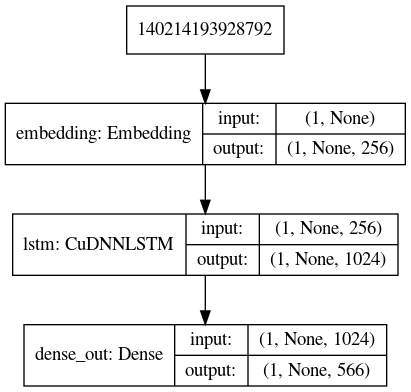

In [31]:
from keras.utils import plot_model
from IPython.display import Image
plot_model(model, show_shapes=True, show_layer_names=True, to_file='rnnlm.png')
Image(retina=True, filename='rnnlm.png')

In [39]:
def generate_text(model, start_string):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 1000

    # Converting our start string to numbers (vectorizing)
    input_eval = [word_to_index[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperatures results in more predictable text.
    # Higher temperatures results in more surprising text.
    # Experiment to find the best setting.
    temperature = 0.5

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a multinomial distribution to predict the word returned by the model
        predictions = predictions / temperature
        predicted_id = tf.multinomial(predictions, num_samples=1)[-1,0].numpy()

        # We pass the predicted word as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(index_to_word[predicted_id])

    return (start_string + ''.join(text_generated))

In [47]:
print(generate_text(model, start_string=u"Tariffs "))

Tariffs 🎆a a DOJ of the Justice Department of Congress for Trump Tower in Charlottesville, North Carolina tomorrow in San Jose was great. And they want to do a thing out of the U.S. Senate in the U.S. Senate is a special interest money and continues to get this country back on the Trump Administration is not a political reporting that the United States want to have the guts to start out of the next president than any other countries for the FBI and the Democrats on a great job as to the great people of our Vets, and failed by the Democrats will see what happened to sell this for our country has the guts for a great work.
Entrepreneurs: Best person who was an extraordinary interests are amazing that he is a terrible job. I have never been asked for the fight of the U.S. Senate. Sad!
The Democrats are on the debate tonight at 7:00 A.M. to discuss the polls are trying to happen to the U.S. Senate. He wants to see you there!
Congratulations to @TrumpDoral in Florida - thank you! #Trump2016